In [1]:
import numpy as np
from tabulate import tabulate
from astropy.table import Table, join
from astropy.coordinates import SkyCoord, Galactocentric, CylindricalRepresentation, CylindricalDifferential, CartesianDifferential
import astropy.units as u
from astropy.table import Table
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import seaborn as sns
from scipy.stats import norm

# Attempts to Increase Dimensionality of Apogee 
### High Dimensional Evidence for need of more dimensions
- The Gaussian Mixture Model performance shows that Aurora is the only meaningful population (ie. non background noise) lost when reducing from 7 to 5 Gaussian components in APOGEE.
- This show that high-dimensional clustering fails to reliably distinguish Aurora, particularly from GS/E 2 (the “alpha plateau” group) and the Splash population — a contrast to GALAH, where Aurora is more cleanly separated.
- This shows the issues of the current dimensionality to fully resolve overlapping populations.
- Suggests the need for additional informative dimensions, either chemical or dynamical.
### Low Dimensional Evidence for the need of dimensions
- Dimensionality reduction has helped support this case as we look at the `evolution` and instability of the cluster boundaries, where Aurora often overlaps or splits from Splash and GS/E 2.
- These lack of clear and incorrect separation in low-dimensional projections, reinforcing the idea that more discriminative features are needed.
- Shown in Belokurov et al. (2020) in “From dawn till disc”:
    - Aurora stars formed before the Milky Way spun up into a coherent disc, representing an early, chaotic epoch of galaxy assembly.
	- Splash stars, by contrast, formed from a disrupted disc during the GS/E merger, retaining high rotational coherence.
- From a kinematic perspective, the key difference is in the azimuthal velocity ($V_\phi$):
	- Aurora stars exhibit broad, low-spin $V_\phi$ distributions (i.e., minimal net rotation).
	- Splash stars retain higher, more coherent $V_\phi$ values consistent with their disc origin ($V_\phi$ $\approx$ 150 km/s)

---
## However:
- Within our original data cuts, we have applied an eccentricity cut of >0.85, removing most stars on near-circular, rotationally-supported orbits
- These typically correspond to those with greater angular momentum and higher azimuthal velocity $V_\phi$.

Practically:
- Stars with low eccentricity ($e \sim 0$) follow near-circular orbits — like those in the disc — and typically have:
  - $V_\phi \sim 220\ \mathrm{km/s}$
- By imposing $e > 0.85$, we have selected:
  - Stars on radial orbits with low angular momentum, where $V_\phi$ is often:
    - Near zero (randomized motion)
---
### Overall
- So this distribution is biased at onset and not valid to be incorporated

In [33]:
# Load the star data that was used in the GMM clustering on the APOGEE data
apogee_data_highdim_clustering = Table.read('XD_Results/Apogee_postGMM/apogee_GMM_scaled_Gauss7_results.fits', format='fits')
GMM_labels = np.array(apogee_data_highdim_clustering['max_gauss'])

# Load full original APOGEE catalog
all_apogee = Table.read("data/raw/Total_Apogee/ApogeeDR17_allStarLite.fits")

# The required columns from the APOGEE catalog that will allow the calculation of the Azimuthal velocity
# [ID for matching, RA, DEC, proper motion in RA, proper motion in DEC, photogeometric distance, and radial velocity]
# Apogee's radial velocity is used as it is more accurate than Gaia's
needed_cols = ['APOGEE_ID', 'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMDEC', 'GAIAEDR3_R_MED_PHOTOGEO', 'VHELIO_AVG']
all_apogee = all_apogee[needed_cols]

# Rename columns to enable matched joining (as cluster data has lowercase 'apogee_id')
all_apogee.rename_column('APOGEE_ID', 'apogee_id')

# Join the tables together based on the 'APOGEE_ID' column
matched = join(apogee_data_highdim_clustering, all_apogee, keys='apogee_id', join_type='inner')
# Avoid duplicate columns by only taking the first occurrence of each column
unique_ids, first_indices = np.unique(matched['apogee_id'], return_index=True)
matched_unique = matched[first_indices]
matched = matched_unique

# Define Galactocentric frame with custom solar motion
v_sun = CartesianDifferential([11.1, 245., 7.25] * u.km/u.s)
gc_frame = Galactocentric(galcen_distance=8.1 * u.kpc, z_sun=25. * u.pc, galcen_v_sun=v_sun)

# Construct SkyCoord with proper motion, photogeometric distance, and APOGEE radial velocity
coord = SkyCoord(ra=matched['RA'] * u.deg,
                 dec=matched['DEC'] * u.deg,
                 distance=matched['GAIAEDR3_R_MED_PHOTOGEO'] * u.pc,
                 pm_ra_cosdec=matched['GAIAEDR3_PMRA'] * u.mas/u.yr,
                 pm_dec=matched['GAIAEDR3_PMDEC'] * u.mas/u.yr,
                 radial_velocity=matched['VHELIO_AVG'] * u.km/u.s,
                 frame='icrs')

# Ensure that there was a match for all the stars in the original star data
print(f"Length of original star_data_edit: {len(apogee_data_highdim_clustering)}")
print(f"Length of matched table: {len(matched)}")

Length of original star_data_edit: 1612
Length of matched table: 1612


In [34]:
# Transform to Galactocentric and set cylindrical representation
galcen_coords = coord.transform_to(gc_frame)
galcen_coords.representation_type = 'cylindrical'

# Extract position and velocity in cylindrical form
cg_cyl = galcen_coords.represent_as(CylindricalRepresentation)
cg_cyl_vel = galcen_coords.represent_as(CylindricalRepresentation, CylindricalDifferential).differentials['s']

# Convert d_phi (rad/yr) to rad/s and rho (pc) to km
d_phi_rad_s = cg_cyl_vel.d_phi.to(u.rad / u.s)
rho_km = cg_cyl.rho.to(u.km)

# Compute v_phi (linear azimuthal velocity) with negative sign
v_phi_kms = -(d_phi_rad_s * rho_km)

# Clean and convert for use
vphi_vals = v_phi_kms.value
mask = ~np.isnan(vphi_vals) & ~np.isnan(GMM_labels)
vphi_vals_clean = vphi_vals[mask]
labels_clean = GMM_labels[mask].astype(int)

# --- Print basic stats ---
print(f"Original sample size: {len(apogee_data_highdim_clustering)}")
print(f"Matched sample size: {len(matched)}")
print(f"Clean v_phi count: {len(vphi_vals_clean)}")
print(f"v_phi NaNs: {np.sum(np.isnan(vphi_vals))}")

Original sample size: 1612
Matched sample size: 1612
Clean v_phi count: 1611
v_phi NaNs: 1


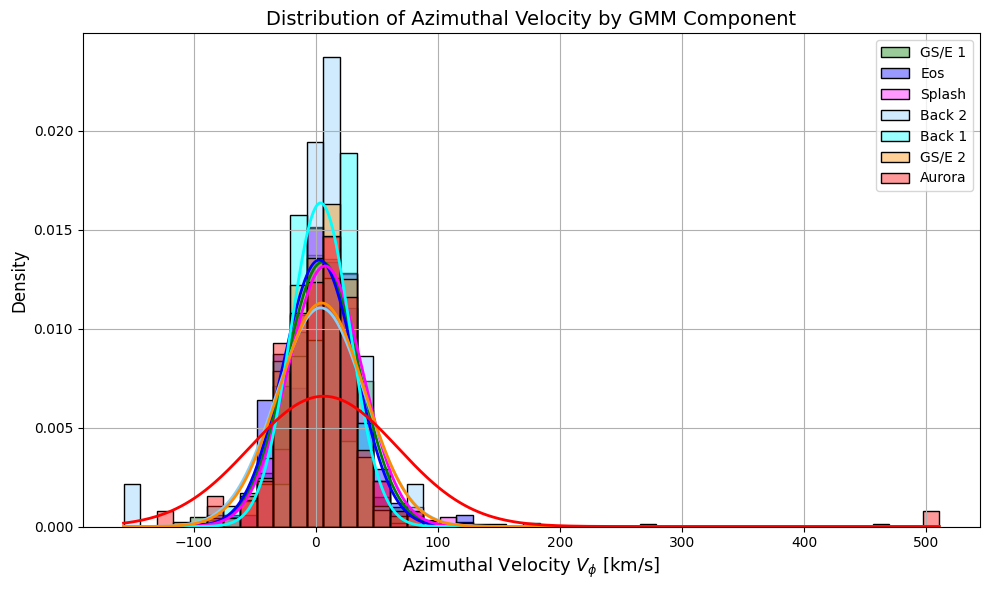

+-------------+---------+---------------------+------------------+
| Component   |   Count |   Mean V_phi (km/s) |   Std Dev (km/s) |
+=============+=========+=====================+==================+
| GS/E 1      |     299 |                5.12 |            29.87 |
+-------------+---------+---------------------+------------------+
| Eos         |     126 |                2.67 |            29.65 |
+-------------+---------+---------------------+------------------+
| Splash      |     447 |                7.46 |            30.31 |
+-------------+---------+---------------------+------------------+
| Back 2      |      34 |                3.87 |            36.12 |
+-------------+---------+---------------------+------------------+
| Back 1      |      70 |                3.71 |            24.41 |
+-------------+---------+---------------------+------------------+
| GS/E 2      |     540 |                4.69 |            35.34 |
+-------------+---------+---------------------+---------------

In [35]:
# Mapping from component label to names
label_names = {
    1: "GS/E 1",
    6: "GS/E 2",
    3: "Splash",
    7: "Aurora",
    2: "Eos",
    5: "Back 1",
    4: "Back 2"
}

# color palette 
color_palette = [
    "green",       
    "blue",        
    "magenta",
    "lightskyblue",
    "cyan",        
    "darkorange",  
    "red"         
]

# Plot distribution of azimuthal velocity by GMM label
plt.figure(figsize=(10, 6))
bins = np.linspace(np.nanmin(vphi_vals_clean), np.nanmax(vphi_vals_clean), 50)

# Loop through each GMM component and plot histogram and Gaussian overlay
for label in sorted(np.unique(labels_clean)):
    if label not in label_names:
        continue
    name = label_names[label]
    color = color_palette[label - 1]

    # Identify the subset of data for the current GMM component
    subset = vphi_vals_clean[labels_clean == label]
    sns.histplot(subset, bins=bins, kde=False, stat='density',
                 label=name, color=color, alpha=0.4)

    mu, std = np.mean(subset), np.std(subset)
    x_range = np.linspace(np.min(vphi_vals_clean), np.max(vphi_vals_clean), 500)
    plt.plot(x_range, norm.pdf(x_range, mu, std), color=color, lw=2)

plt.xlabel(r"Azimuthal Velocity $V_\phi$ [km/s]", fontsize=13)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution of Azimuthal Velocity by GMM Component", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary statistics table
summary_rows = []
for label in sorted(np.unique(GMM_labels)):
    if label not in label_names:
        continue
    mask = GMM_labels == label
    subset = vphi_vals[mask]
    subset = subset[~np.isnan(subset)]
    count = len(subset)
    mean = np.mean(subset)
    std = np.std(subset)
    summary_rows.append([label_names[label], count, f"{mean:.2f}", f"{std:.2f}"])

# Print formatted table
print(tabulate(summary_rows, headers=["Component", "Count", "Mean V_phi (km/s)", "Std Dev (km/s)"], tablefmt="grid"))


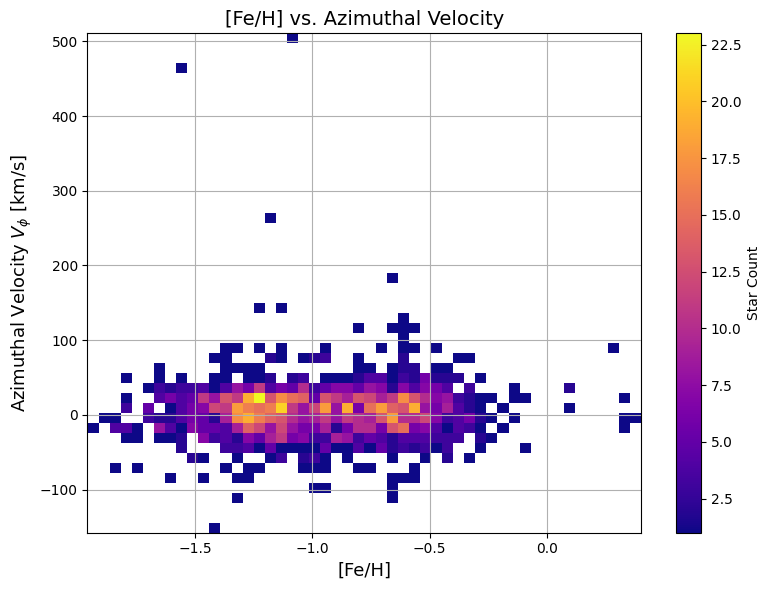

In [36]:
# Filter values
mask = ~np.isnan(vphi_vals) & ~np.isnan(GMM_labels)
feh_vals_subset = apogee_data_highdim_clustering['fe_h'][mask]
vphi_vals_filtered_subset = vphi_vals_clean

# Plot
plt.figure(figsize=(8, 6))
plt.hist2d(feh_vals_subset, vphi_vals_filtered_subset, bins=(50, 50), cmap='plasma', cmin=1)
plt.xlabel(r"[Fe/H]", fontsize=13)
plt.ylabel(r"Azimuthal Velocity $V_\phi$ [km/s]", fontsize=13)
plt.title("[Fe/H] vs. Azimuthal Velocity", fontsize=14)
plt.colorbar(label="Star Count")
plt.grid(True)
plt.tight_layout()
plt.show()

- Here we show that we have shown that eccentricity cut does make the azimenthal space likely unadvantagous to add to our clustering space, with a similiar logic followed for the majority of dynamical properties.

## Plot for full apogee population

In [37]:
# Load full original APOGEE catalog
all_apogee = Table.read("data/raw/Total_Apogee/ApogeeDR17_allStarLite.fits")

# The required columns from the APOGEE catalog that will allow the calculation of the Azimuthal velocity
# [ID for matching, RA, DEC, proper motion in RA, proper motion in DEC, photogeometric distance, and radial velocity]
# Apogee's radial velocity is used as it is more accurate than Gaia's
needed_cols = ['APOGEE_ID', 'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMDEC', 'GAIAEDR3_R_MED_PHOTOGEO', 'VHELIO_AVG', 'FE_H']
all_apogee = all_apogee[needed_cols]


In [38]:
# Define Galactocentric frame with custom solar motion
v_sun = CartesianDifferential([11.1, 245., 7.25] * u.km/u.s)
gc_frame = Galactocentric(galcen_distance=8.1 * u.kpc, z_sun=25. * u.pc, galcen_v_sun=v_sun)

# Construct SkyCoord with proper motion, photogeometric distance, and APOGEE radial velocity
coord = SkyCoord(ra=all_apogee['RA'] * u.deg,
                 dec=all_apogee['DEC'] * u.deg,
                 distance=all_apogee['GAIAEDR3_R_MED_PHOTOGEO'] * u.pc,
                 pm_ra_cosdec=all_apogee['GAIAEDR3_PMRA'] * u.mas/u.yr,
                 pm_dec=all_apogee['GAIAEDR3_PMDEC'] * u.mas/u.yr,
                 radial_velocity=all_apogee['VHELIO_AVG'] * u.km/u.s,
                 frame='icrs')

In [39]:
# Transform to Galactocentric and set cylindrical representation
galcen_coords = coord.transform_to(gc_frame)
galcen_coords.representation_type = 'cylindrical'

# Extract position and velocity in cylindrical form
cg_cyl = galcen_coords.represent_as(CylindricalRepresentation)
cg_cyl_vel = galcen_coords.represent_as(CylindricalRepresentation, CylindricalDifferential).differentials['s']

# Convert d_phi (rad/yr) to rad/s and rho (pc) to km
d_phi_rad_s = cg_cyl_vel.d_phi.to(u.rad / u.s)
rho_km = cg_cyl.rho.to(u.km)

# Compute v_phi (linear azimuthal velocity) with negative sign
v_phi_kms_all = -(d_phi_rad_s * rho_km)

In [40]:
# Clean and convert for use
vphi_vals_all = v_phi_kms_all.value
mask = ~np.isnan(vphi_vals_all) & ~np.isnan(all_apogee['FE_H'])
vphi_vals_clean = vphi_vals_all[mask]
# 
feh_vals = all_apogee['FE_H'][mask]
vphi_vals_filtered = vphi_vals_clean


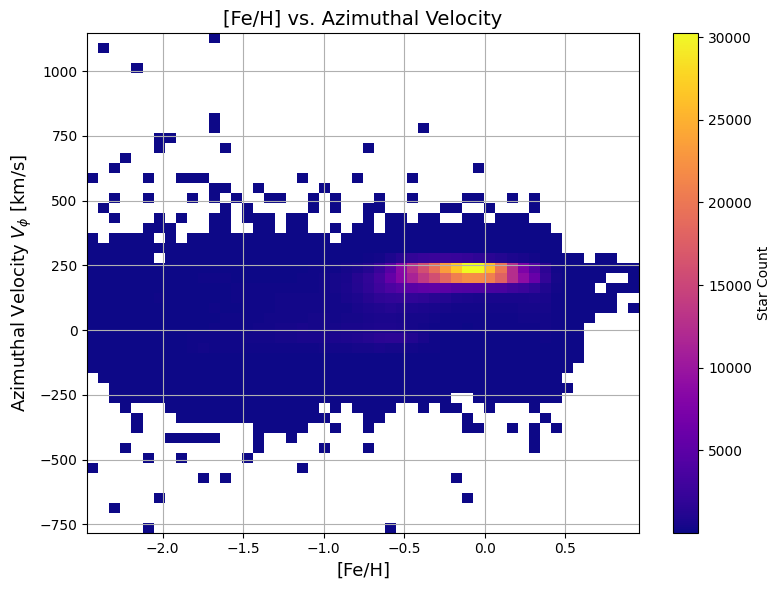

In [45]:

# Plot
plt.figure(figsize=(8, 6))
plt.hist2d(feh_vals, vphi_vals_filtered, bins=(50, 50), cmap='plasma', cmin=1)
plt.xlabel(r"[Fe/H]", fontsize=13)
plt.ylabel(r"Azimuthal Velocity $V_\phi$ [km/s]", fontsize=13)
plt.title("[Fe/H] vs. Azimuthal Velocity", fontsize=14)
plt.colorbar(label="Star Count")
plt.grid(True)
plt.tight_layout()
plt.show()





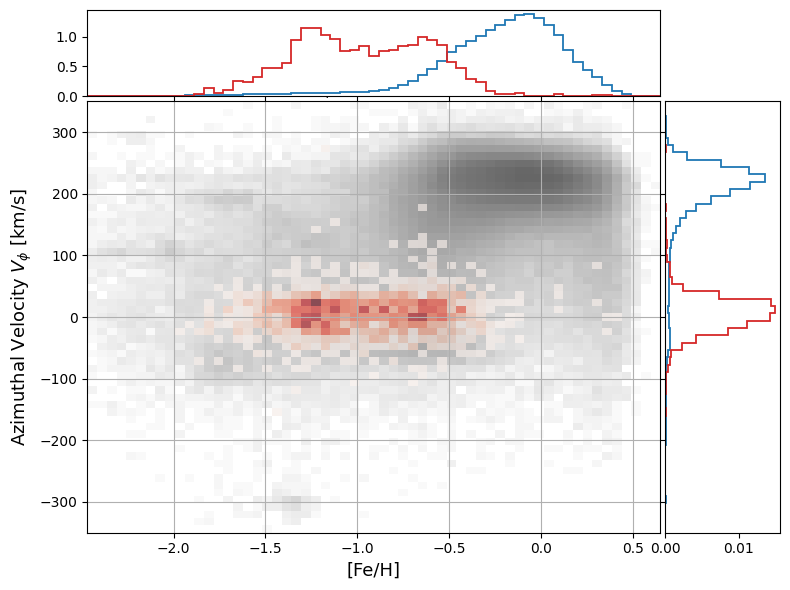

In [64]:
# Define binning manually so both hist2d plots align
x_bins = np.linspace(np.nanmin(feh_vals), 0.65, 60)
y_bins = np.linspace(-350, 350, 60)

# Create figure and axes
fig, ax_main = plt.subplots(figsize=(8, 6))
divider = make_axes_locatable(ax_main)
ax_histx = divider.append_axes("top", size="20%", pad=0.05, sharex=ax_main)
ax_histy = divider.append_axes("right", size="20%", pad=0.05, sharey=ax_main)

# 2D histogram background (full sample)
h1 = ax_main.hist2d(feh_vals, vphi_vals_filtered, bins=[x_bins, y_bins], cmap='Greys', norm=LogNorm(), cmin=1, alpha=0.6)
# 2D histogram overlay (subset)
h2 = ax_main.hist2d(feh_vals_subset, vphi_vals_filtered_subset, bins=[x_bins, y_bins], cmap='Reds', cmin=1, alpha=0.6)

# Set x and y limits explicitly
ax_main.set_xlim(np.nanmin(feh_vals), 0.65)
ax_main.set_ylim(-350, 350)

# Labels and title
ax_main.set_xlabel(r"[Fe/H]", fontsize=13)
ax_main.set_ylabel(r"Azimuthal Velocity $V_\phi$ [km/s]", fontsize=13)
ax_main.set_title(r"[Fe/H] vs. $V_\phi$ with Subset Overlay", fontsize=14)

# Marginal histograms (Top X, normalized)
ax_histx.hist(feh_vals, bins=x_bins, density=True, color='tab:blue', histtype='step', linewidth=1.3, label='Full Sample')
ax_histx.hist(feh_vals_subset, bins=x_bins, density=True, color='tab:red', histtype='step', linewidth=1.3, label='Subset')

# Marginal histograms (Right Y, normalized)
ax_histy.hist(vphi_vals_filtered, bins=y_bins, density=True, orientation='horizontal', color='tab:blue', histtype='step', linewidth=1.3)
ax_histy.hist(vphi_vals_filtered_subset, bins=y_bins, density=True, orientation='horizontal', color='tab:red', histtype='step', linewidth=1.3)

# Hide tick labels for histograms
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)

# Tick formatting
ax_histx.tick_params(axis='y', labelsize=10)
ax_histy.tick_params(axis='x', labelsize=10)

# Grid and layout
ax_main.grid(True)
fig.tight_layout()
plt.show()